# Goal

There is a need to respond quickly to changes in today's world. This response may sometimes require understanding of a topic. Given any topic, there is a plethora of sources providing seas of data related to the it. Given todays world condition, a global concern is the treatment and handling of the COVID-19 pandemic. Given the rising amount of literature regarding the subject, it will be difficult for a scientist to keep up with today's literature.
> Is it possible to cluster these tens of thousands of articles to make it easier for a scientist to find relevant research articles?



In [7]:
from datetime import datetime
start_time = datetime.now()
import pandas as pd
import os
import json
import glob
import matplotlib.pyplot as plt
from hdfs import InsecureClient

end_time = datetime.now()
print(f'Time for imports only: {end_time-start_time}')

Time for imports only: 0:00:00.000333


## Reading all files into Spark RDDs with PySpark

In [8]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName("SparkTFIDF")
sc = SparkContext(conf=conf)

hdfs_folder = 'hdfs://madison:31802/cord19dataset/metadata.csv'

def read_data(hdfs_folder):
    data = sc.parallelize([])
    data = sc.textFile(hdfs_folder)
    return data

meta = read_data(hdfs_folder)
sc.stop()

In [9]:
meta

hdfs://madison:31802/cord19dataset/metadata.csv MapPartitionsRDD[2] at textFile at NativeMethodAccessorImpl.java:0

## Reading all files from HDFS

In [10]:
client_hdfs = InsecureClient('http://madison:31802')

In [11]:
client_hdfs.content('/cord19dataset')

{'directoryCount': 17,
 'fileCount': 59317,
 'length': 7913288034,
 'quota': -1,
 'spaceConsumed': 23739864102,
 'spaceQuota': -1,
 'typeQuota': {}}

In [12]:
fnames = client_hdfs.list('/cord19dataset')
fnames

['COVID.DATA.LIC.AGMT.pdf',
 'biorxiv_medrxiv',
 'biorxiv_medrxiv.tar.gz',
 'comm_use_subset',
 'cord19_specter_embeddings_2020-04-10',
 'custom_license',
 'json_schema.txt',
 'metadata.csv',
 'metadata.readme',
 'noncomm_use_subset']

In [13]:
fnames = client_hdfs.list('/cord19dataset/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json')
fnames[0:50]

['0015023cc06b5362d332b3baf348d11567ca2fbb.json',
 '00340eea543336d54adda18236424de6a5e91c9d.json',
 '004f0f8bb66cf446678dc13cf2701feec4f36d76.json',
 '00911cf4f99a3d5ae5e5b787675646a743574496.json',
 '00d16927588fb04d4be0e6b269fc02f0d3c2aa7b.json',
 '00eb9220dc8cd351393b6b035323d350f103f8c6.json',
 '0139ea4ca580af99b602c6435368e7fdbefacb03.json',
 '013d9d1cba8a54d5d3718c229b812d7cf91b6c89.json',
 '018fb5e62fbbcae07d57d94d29ac630dcc4dccf9.json',
 '01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18.json',
 '01e3b313e78a352593be2ff64927192af66619b5.json',
 '02201e4601ab0eb70b6c26480cf2bfeae2625193.json',
 '0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5.json',
 '029c1c588047f1d612a219ee15494d2d19ff7439.json',
 '0313c3faa16cd66d64f31ae37e40fb70695d69fb.json',
 '033ea7af3e6137df652de026f0751ac435327b75.json',
 '03813d8657ba43ea382788caec2d14257b26d8fd.json',
 '03ce432f27c7df6af22b92245a614db2ecb5de5f.json',
 '03ea3a614b56409d3f099c9ad764864293132540.json',
 '03ea9ad47ebe9a599205b99390c45490e6724024.json',


In [14]:
##It is possible to loop through all the folders and sub folders while using 
##content(<path>,strict=False) != None as a breaking condition`

In [15]:
#There is also this provided snippet to get all files under a given directory
# Get all files under a given folder (arbitrary depth).
import posixpath as psp
fpaths = [
  psp.join(dpath, fname)
  for dpath, _, fnames in client_hdfs.walk('/cord19dataset')
  for fname in fnames
]
len(fpaths)

59317

In [16]:
fpaths_json = list(filter(lambda x: ".json" in x,fpaths))

len(fpaths_json)

59311

In [17]:
_125hdfsjson = fpaths_json[0:12500]

## Metadata for the database

We are given a metadata file that gives us the filename of each article along with its abstract and some other details such as date published and journal that it was published in.

In [18]:
root_path = '/cord19dataset'

In [19]:
with client_hdfs.read(f'{root_path}/metadata.csv', encoding = 'utf-8') as reader:
    meta = pd.read_csv(reader)

meta.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
0,xqhn0vbp,1e1286db212100993d03cc22374b624f7caee956,PMC,Airborne rhinovirus detection and effect of ul...,10.1186/1471-2458-3-5,PMC140314,12525263.0,no-cc,"BACKGROUND: Rhinovirus, the most common cause ...",2003-01-13,"Myatt, Theodore A; Johnston, Sebastian L; Rudn...",BMC Public Health,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
1,gi6uaa83,8ae137c8da1607b3a8e4c946c07ca8bda67f88ac,PMC,Discovering human history from stomach bacteria,10.1186/gb-2003-4-5-213,PMC156578,12734001.0,no-cc,Recent analyses of human pathogens have reveal...,2003-04-28,"Disotell, Todd R",Genome Biol,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
2,le0ogx1s,NaN,PMC,A new recruit for the army of the men of death,10.1186/gb-2003-4-7-113,PMC193621,12844350.0,no-cc,"The army of the men of death, in John Bunyan's...",2003-06-27,"Petsko, Gregory A",Genome Biol,NaN,NaN,False,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...
3,fy4w7xz8,0104f6ceccf92ae8567a0102f89cbb976969a774,PMC,Association of HLA class I with severe acute r...,10.1186/1471-2350-4-9,PMC212558,12969506.0,no-cc,BACKGROUND: The human leukocyte antigen (HLA) ...,2003-09-12,"Lin, Marie; Tseng, Hsiang-Kuang; Trejaut, Jean...",BMC Med Genet,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...
4,0qaoam29,5b68a553a7cbbea13472721cd1ad617d42b40c26,PMC,A double epidemic model for the SARS propagation,10.1186/1471-2334-3-19,PMC222908,12964944.0,no-cc,BACKGROUND: An epidemic of a Severe Acute Resp...,2003-09-10,"Ng, Tuen Wai; Turinici, Gabriel; Danchin, Antoine",BMC Infect Dis,NaN,NaN,True,True,custom_license,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...


In [20]:
meta.count()

cord_uid                       51078
sha                            38022
source_x                       51078
title                          50920
doi                            47741
pmcid                          41082
pubmed_id                      37861
license                        51078
abstract                       42352
publish_time                   51070
authors                        48891
journal                        46368
Microsoft Academic Paper ID      964
WHO #Covidence                  1768
has_pdf_parse                  51078
has_pmc_xml_parse              51078
full_text_file                 42511
url                            50776
dtype: int64

In [21]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 18 columns):
cord_uid                       51078 non-null object
sha                            38022 non-null object
source_x                       51078 non-null object
title                          50920 non-null object
doi                            47741 non-null object
pmcid                          41082 non-null object
pubmed_id                      37861 non-null float64
license                        51078 non-null object
abstract                       42352 non-null object
publish_time                   51070 non-null object
authors                        48891 non-null object
journal                        46368 non-null object
Microsoft Academic Paper ID    964 non-null float64
WHO #Covidence                 1768 non-null object
has_pdf_parse                  51078 non-null bool
has_pmc_xml_parse              51078 non-null bool
full_text_file                 42511 non-null ob

Let us look at the column marked "SHA". At a closer look, we can see that it seems to be a hash of some kind.

But looking into the folders, we see that this unique hash has been ingeniously used to identify each file. i.e. We don't need to refer to a long paper title to find its file contents. Instead we can just scan the home directory for a file with that hash.json.

In [22]:
meta["sha"][0]

'1e1286db212100993d03cc22374b624f7caee956'

In [23]:
bio= meta.loc[meta['source_x'] == 'biorxiv']
bio.head()
bio.iloc[1]['sha']

'daf32e013d325a6feb80e83d15aabc64a48fae33'

Now the source_x column is of importance for us as well. It refers to the source journal of each paper. This is important because the papers have been organized into folders, each representing a different source. e.g. a biorxiv folder, a WHO document folder etc.

In [24]:
meta.source_x.unique()

array(['PMC', 'Elsevier', 'CZI', 'WHO', 'biorxiv', 'medrxiv'],
      dtype=object)

Let us read some of the biorxiv files into variables to see the structure as viewed in the screenshot before section 2.1.

In [25]:
for i in range(1):
    with client_hdfs.read(fpaths_json[i]) as reader:
        from json import load
        print(load(reader))

{'paper_id': '0015023cc06b5362d332b3baf348d11567ca2fbb', 'metadata': {'title': 'The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3', 'authors': [{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Chris', 'middle': [], 'last': 'Neil', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Sarah', 'middle': [], 'last': '', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': '', 'middle': [], 'last': 'Gold', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Niall', 'middle': [], 'last': 'Mclean', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Caroline', 'middle': [], 'last': 'Wright', 'suffix': '', 'a

In [26]:
articles = {}
for i in range(1):
    with client_hdfs.read(fpaths_json[i]) as reader:
        from json import load
        articles[i] = load(reader)

articles[0].keys()

dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])

From above, we can see that there are keys that describe each paper of the biorxiv journal. Of these, Our paritcular interest lies in the abstract and the body_text. The title is useful too, and to get it, we have to look inside the metadata part of the file. 

In [27]:
articles[0]['metadata'].keys()

dict_keys(['title', 'authors'])

If printed as a whole, each file would look like the below output:

In [28]:
with client_hdfs.read(f'{fpaths_json[0]}', encoding = 'utf-8') as reader:
    f = json.load(reader)
    print(type(f),f['metadata'])

<class 'dict'> {'title': 'The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3', 'authors': [{'first': 'Joseph', 'middle': ['C'], 'last': 'Ward', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Lidia', 'middle': [], 'last': 'Lasecka-Dykes', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Chris', 'middle': [], 'last': 'Neil', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Oluwapelumi', 'middle': [], 'last': 'Adeyemi', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Sarah', 'middle': [], 'last': '', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': '', 'middle': [], 'last': 'Gold', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Niall', 'middle': [], 'last': 'Mclean', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Caroline', 'middle': [], 'last': 'Wright', 'suffix': '', 'affiliation': {}, 'email': ''}, {'first': 'Morgan', 'mi

In [29]:
with client_hdfs.read(f'{fpaths_json[0]}', encoding = 'utf-8') as reader:
    f = json.load(reader)
    for line in f:
        print(line)

paper_id
metadata
abstract
body_text
bib_entries
ref_entries
back_matter


## How to load and read a json file

In [30]:
def load_json(filename):
    with open(filename +  ".json") as f:
        data = json.load(f)
    return data

## Reading all files from local disk

Since our dataset is not prohibitively large(7-8GB) it is easilty possible to reado it from disk as shown below

Code to read all json files in the directory in one go (Cite: [Kernel on Kaggle](https://www.kaggle.com/maksimeren/covid-19-literature-clustering))

In [31]:
all_json = glob.glob(f'/s/chopin/b/grad/sanketm/cord19dataset/**/*.json', recursive=True)
len(all_json)

59311

In [32]:
all_json[0]

'/s/chopin/b/grad/sanketm/cord19dataset/noncomm_use_subset/noncomm_use_subset/pdf_json/e6d882be4961d1bdd7507b4a29d86b650de0895d.json'

In [33]:
_125json = all_json[0:12500]
_125json[0]

'/s/chopin/b/grad/sanketm/cord19dataset/noncomm_use_subset/noncomm_use_subset/pdf_json/e6d882be4961d1bdd7507b4a29d86b650de0895d.json'

In [34]:
fpaths_json[0]

'/cord19dataset/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/0015023cc06b5362d332b3baf348d11567ca2fbb.json'

Let's make a class so that we could refer to the loaded articles easily

In [35]:
class Article:
    
    def __init__(self,filepath):
        with client_hdfs.read(filepath,encoding='utf=8') as f:
            metadata = json.load(f)
            self.paper_id = metadata['paper_id']
            self.title = metadata['metadata']['title']
            self.abstract = ""
            self.body_text = ""
            
            #Abstract
            try:
                for entry in metadata['abstract']:
                    self.abstract += str(entry['text'])
            except:
                pass
                
            

            #body_text
            for entry in metadata['body_text']:
                self.body_text += str(entry['text'])


            
    def __repr__(self):
        return f'Article Object with id: {self.paper_id} \n title:{self.title} \n abstract:{self.abstract}'
            
                       

In [36]:
articles = {}
for i in range(2):
        print(Article(fpaths_json[i]),"\n\n\n\n")

Article Object with id: 0015023cc06b5362d332b3baf348d11567ca2fbb 
 title:The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3 
 abstract:word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). 

In [37]:
articles = {}
for i in range(2):
        articles[i] = Article(fpaths_json[i])

In [38]:
articles[0].abstract

'word count: 194 22 Text word count: 5168 23 24 25 author/funder. All rights reserved. No reuse allowed without permission. Abstract 27 The positive stranded RNA genomes of picornaviruses comprise a single large open reading 28 frame flanked by 5′ and 3′ untranslated regions (UTRs). Foot-and-mouth disease virus (FMDV) 29 has an unusually large 5′ UTR (1.3 kb) containing five structural domains. These include the 30 internal ribosome entry site (IRES), which facilitates initiation of translation, and the cis-acting 31 replication element (cre). Less well characterised structures are a 5′ terminal 360 nucleotide 32 stem-loop, a variable length poly-C-tract of approximately 100-200 nucleotides and a series of 33 two to four tandemly repeated pseudoknots (PKs). We investigated the structures of the PKs 34 by selective 2′ hydroxyl acetylation analysed by primer extension (SHAPE) analysis and 35 determined their contribution to genome replication by mutation and deletion experiments. 36 SHAP

In [39]:
articles[1]

Article Object with id: 00340eea543336d54adda18236424de6a5e91c9d 
 title:Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications 
 abstract:During the past three months, a new coronavirus (SARS-CoV-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. A plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate SARS-CoV-2 genetic heterogeneity and spatiotemporal dissemination. We examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. Our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. Hence the need for avoiding sti

# Data Cleaning

Now that we have explored the structure of the dataset, let us focus on our areas of interest as mentioned earlier: namely the Title, Abstract and the body of the text.\
We know that we can access these for a given paper by scanning the metadata for a paper of choice for its title and abstract, and if we need it, using its `sha` column value to get the full text of the paper.

First let us clean the metadata by dropping all NA valued rows for the title, sha and abstract columns.

[Pandas filter rows](https://stackoverflow.com/questions/17071871/how-to-select-rows-from-a-dataframe-based-on-column-values)

In [40]:
bio= meta.loc[meta['source_x'] == 'biorxiv']

print(f'Meta count:{len(meta)} biorxiv papers count: {len(bio)}')

bio_clean = bio.drop_duplicates().dropna()

len(bio_clean)

Meta count:51078 biorxiv papers count: 764


0

Using the above dropna condition doesn't work out,  number of rows in the resulting dataframe is zero.
We found a solution Cite: [stack overflow post](https://stackoverflow.com/questions/39241346/pandas-dropna-on-specify-attribute)

In [41]:
bio_clean = bio.loc[~(bio.sha.isnull())]

len(bio_clean)

bio_clean.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,Microsoft Academic Paper ID,WHO #Covidence,has_pdf_parse,has_pmc_xml_parse,full_text_file,url
32366,vho70jcx,f056da9c64fbf00a4645ae326e8a4339d015d155,biorxiv,SIANN: Strain Identification by Alignment to N...,10.1101/001727,NaN,NaN,biorxiv,Next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/001727
32367,i9tbix2v,daf32e013d325a6feb80e83d15aabc64a48fae33,biorxiv,Spatial epidemiology of networked metapopulati...,10.1101/003889,NaN,NaN,biorxiv,An emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/003889
32368,62gfisc6,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,biorxiv,Sequencing of the human IG light chain loci fr...,10.1101/006866,NaN,NaN,biorxiv,Germline variation at immunoglobulin gene (IG)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/006866
32369,058r9486,4da8a87e614373d56070ed272487451266dce919,biorxiv,Bayesian mixture analysis for metagenomic comm...,10.1101/007476,NaN,NaN,biorxiv,Deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/007476
32370,wich35l7,eccef80cfbe078235df22398f195d5db462d8000,biorxiv,Mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,NaN,NaN,biorxiv,Developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,NaN,NaN,NaN,True,False,biorxiv_medrxiv,https://doi.org/10.1101/010389


Now we can remove columns that are unneeded or have only nan values

In [42]:
print(bio_clean['source_x'].unique(),
bio_clean['pmcid'].unique(),
bio_clean['pubmed_id'].unique(),
bio_clean['Microsoft Academic Paper ID'].unique(),
bio_clean['WHO #Covidence'].unique())

['biorxiv'] [nan] [nan] [nan] [nan]


In [43]:
bio_slim = bio_clean.drop(['Microsoft Academic Paper ID','WHO #Covidence','pubmed_id','pmcid'], axis = 1)

bio_slim = bio_slim.drop(['url','doi','license','full_text_file'],axis =1 )

bio_slim = bio_slim[~bio_slim.has_pdf_parse.isin(['False'])]

bio_slim =bio_slim.loc[~(bio_slim.abstract.isnull())]

As we had seen at the send of section 2.3, `fpaths_json` contains the paths of all the json files(i.e. the articles) in it.
Now we should load this into a dataframe for it to be queryable

In [44]:
start_time = datetime.now()
dict_ = {'paper_id': [], 'abstract': [], 'body_text': [], 'authors': [], 'title': []}
for idx, entry in enumerate(_125hdfsjson):
    if idx % (len(_125hdfsjson) // 10) == 0:
        print(f'Processing index: {idx} of {len(_125hdfsjson)}')
    content = Article(entry)
    
    # get metadata information
    meta_data = meta.loc[meta['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    

    dict_['body_text'].append(content.body_text)
    
       
    # get metadata information
    meta_data = meta.loc[meta['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # more than 2 authors, may be problem when plotting, so take first 2 append with ...
            dict_['authors'].append(". ".join(authors[:2]) + "...")
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = meta_data['title'].values[0], 40
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
       
    dict_['paper_id'].append(meta_data['sha'].values[0])
    dict_['abstract'].append(meta_data['abstract'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'abstract', 'body_text', 'authors', 'title'])
df_covid.head()
end_time = datetime.now()
print(f' time taken : {(end_time  - start_time)}')

Processing index: 0 of 12500
Processing index: 1250 of 12500
Processing index: 2500 of 12500
Processing index: 3750 of 12500
Processing index: 5000 of 12500
Processing index: 6250 of 12500
Processing index: 7500 of 12500
Processing index: 8750 of 12500
Processing index: 10000 of 12500
Processing index: 11250 of 12500
 time taken : 0:06:42.618265


In [45]:
print(len(dict_['paper_id']),len(dict_['abstract']),len(dict_['body_text']),len(dict_['authors']),len(dict_['title']))

len(df_covid['abstract'][0].strip().split())

10298 10298 10298 10298 10298


194

In [46]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(str(x).strip().split()))
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(str(x).strip().split()))
df_covid['body_unique_words']=df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head(10)

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,AbstractThe positive stranded RNA genomes of p...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,ABSTRARCTThe fast accumulation of viral metage...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,AbstractInfectious bronchitis (IB) causes sign...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199
5,00eb9220dc8cd351393b6b035323d350f103f8c6,"Importance: As with other traumatic events, pa...","Evidence from prior pandemics suggests that, a...",Victor M. Castro. Roy H Perlis,(Impact of COVID-19 on psychiatric assessment ...,246,2103,759
6,0139ea4ca580af99b602c6435368e7fdbefacb03,AbstractBackgroundNipah Virus (NiV) came into ...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,(A Combined Evidence Approach to Prioritize Ni...,326,2382,1034
7,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,Background: A novel coronavirus (2019-nCoV) em...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,(Assessing spread risk of Wuhan novel coronavi...,292,4596,1205
8,018fb5e62fbbcae07d57d94d29ac630dcc4dccf9,Introduction: Recent events highlight how emer...,Recent events highlight how emerging and re-em...,DAVIDE GORI. Erik Boetto...,(Analysis of the scientific literature in the ...,200,2906,1131
9,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,Faced with the current large-scale public heal...,The sudden outbreak of the new coronavirus (SA...,Xiaoyang Ji. Chunming Zhang...,"(TWIRLS, an automated topic-wise inference met...",223,4386,1309


## Dataset statistics <a id='Statistics'></a>

In [48]:
totalnumberofwords_abstract=df_covid['abstract_word_count'].sum()
avg_abstract_len = totalnumberofwords_abstract/len(df_covid['abstract_word_count'])
print(f'Total number of words across all abstracts = {totalnumberofwords_abstract}. Average abstract length = {avg_abstract_len}')

Total number of words across all abstracts = 2272220. Average abstract length = 220.6467275199068


In [49]:
totalnumberofwords_body=df_covid['body_word_count'].sum()
avg_body_len = totalnumberofwords_body/len(df_covid['body_word_count'])
print(f'Total number of words across all body texts = {totalnumberofwords_body}. Average body length = {avg_body_len}')

Total number of words across all body texts = 44276263. Average body length = 4299.501165274811


In [50]:
uniqwords = df_covid['body_unique_words'].sum()
avg_uniq_words = uniqwords/len(df_covid['body_unique_words'])
print(f'Total number of unique words across all body texts: {uniqwords}.')

Total number of unique words across all body texts: 13905462.


Text(0.5, 1.0, 'Abstract word-count')

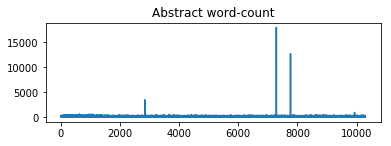

In [51]:
#plot = plt.figure(figsize=(80,80))
ax1 = plt.subplot(2,1,1)
ax1.plot(df_covid['abstract_word_count'])
#plt.xlim(right=2500)
ax1.set_title("Abstract word-count")

Text(0.5, 1.0, 'Article body-text word-count')

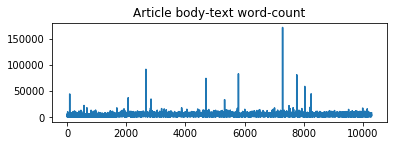

In [52]:
#plot = plt.figure(figsize=(100,108))
ax2 = plt.subplot(2,1,2)
ax2.plot(df_covid['body_word_count'])
ax2.set_title("Article body-text word-count")

count     10298.000000
mean       4299.501165
std        3347.096501
min          15.000000
25%        2686.000000
50%        3853.500000
75%        5423.000000
max      171326.000000
Name: body_word_count, dtype: float64

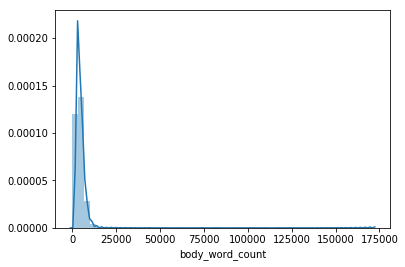

In [53]:
import seaborn as sns
sns.distplot(df_covid['body_word_count'])
df_covid['body_word_count'].describe()

count    10298.00000
mean      1350.30705
std        673.14116
min         15.00000
25%        971.25000
50%       1284.00000
75%       1654.00000
max      25516.00000
Name: body_unique_words, dtype: float64

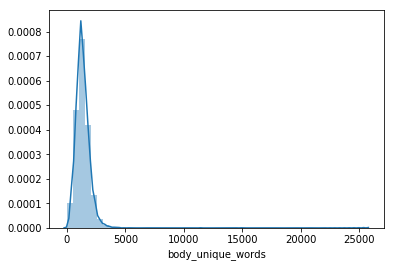

In [54]:
sns.distplot(df_covid['body_unique_words'])
df_covid['body_unique_words'].describe()

count    10298.000000
mean       220.646728
std        232.250953
min          1.000000
25%        168.000000
50%        215.000000
75%        269.000000
max      18000.000000
Name: abstract_word_count, dtype: float64

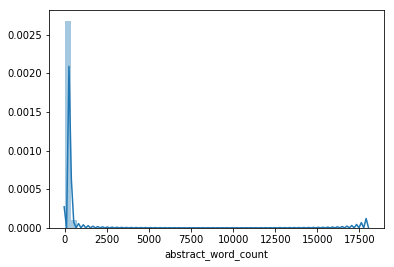

In [55]:
sns.distplot(df_covid['abstract_word_count'])
df_covid['abstract_word_count'].describe()

In [56]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10298 entries, 0 to 10297
Data columns (total 8 columns):
paper_id               10298 non-null object
abstract               10043 non-null object
body_text              10298 non-null object
authors                10277 non-null object
title                  10298 non-null object
abstract_word_count    10298 non-null int64
body_word_count        10298 non-null int64
body_unique_words      10298 non-null int64
dtypes: int64(3), object(5)
memory usage: 643.7+ KB


In [57]:
df_covid['abstract'].describe(include='all')

count                                                 10043
unique                                                10042
top       The purpose of this table is to provide the co...
freq                                                      2
Name: abstract, dtype: object

The difference between the unique count and the total count means that either there are some duplicate abstracts or there are blank abstracts that are being counted as the same. 

In [58]:
df_covid['body_text'].describe(include='all')

count                                                 10298
unique                                                10296
top       Coronaviruses are enveloped positive-sense sin...
freq                                                      2
Name: body_text, dtype: object

The difference between the unique count and the total count means that there are some duplicate articles present in the dataset. This coulde be possible if the authors had sent their papers to different journals.

In [59]:
df_covid.drop_duplicates(['abstract'],inplace=True)

df_covid['abstract'].describe(include='all')

count                                                 10042
unique                                                10042
top       BACKGROUND: Conventionally, a nebulized short-...
freq                                                      1
Name: abstract, dtype: object

In [60]:
df_covid.drop_duplicates(['body_text'],inplace=True)

df_covid['body_text'].describe(include='all')

count                                                 10042
unique                                                10042
top       Cancer is a major cause of death in worldwide....
freq                                                      1
Name: body_text, dtype: object

In [61]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10042 entries, 0 to 10297
Data columns (total 8 columns):
paper_id               10042 non-null object
abstract               10041 non-null object
body_text              10042 non-null object
authors                10032 non-null object
title                  10042 non-null object
abstract_word_count    10042 non-null int64
body_word_count        10042 non-null int64
body_unique_words      10042 non-null int64
dtypes: int64(3), object(5)
memory usage: 706.1+ KB


In [62]:
df_covid.describe()

,abstract_word_count,body_word_count,body_unique_words
count,10042.000000,10042.000000,10042.000000
mean,226.229038,4335.083549,1361.626369
std,232.509374,2989.377797,620.020085
min,1.000000,15.000000,15.000000
25%,173.000000,2755.500000,993.000000
50%,218.000000,3917.000000,1298.000000
75%,270.000000,5461.500000,1666.000000
max,18000.000000,171326.000000,25516.000000


# Data Preprocessing

We now clean the text data so that our key words are clear and we do not have to worry about details we are not concerned about. [ref1](https://towardsdatascience.com/nlp-text-preprocessing-a-practical-guide-and-template-d80874676e79)  [ref2](https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/)

Firstly By now looking at the abstract columns, we must notice that the text scraped from these articles is not perfect.

For example, many of the abstracts start with the word *Abstract* glued to the beginning of the first word of the real abstract body. 

In [63]:
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('Abstract',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('abstract',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('ABSTRACT',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('ABSTRARCT',''))
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).replace('Background',''))
df_covid.head(10)

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,The positive stranded RNA genomes of picornavi...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,We integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,The fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199
5,00eb9220dc8cd351393b6b035323d350f103f8c6,"Importance: As with other traumatic events, pa...","Evidence from prior pandemics suggests that, a...",Victor M. Castro. Roy H Perlis,(Impact of COVID-19 on psychiatric assessment ...,246,2103,759
6,0139ea4ca580af99b602c6435368e7fdbefacb03,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,Nishi Kumari. Ayush Upadhyay...,(A Combined Evidence Approach to Prioritize Ni...,326,2382,1034
7,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,: A novel coronavirus (2019-nCoV) emerged in W...,"In December 2019, a cluster of patients with p...",Shengjie Lai. Isaac Bogoch...,(Assessing spread risk of Wuhan novel coronavi...,292,4596,1205
8,018fb5e62fbbcae07d57d94d29ac630dcc4dccf9,Introduction: Recent events highlight how emer...,Recent events highlight how emerging and re-em...,DAVIDE GORI. Erik Boetto...,(Analysis of the scientific literature in the ...,200,2906,1131
9,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,Faced with the current large-scale public heal...,The sudden outbreak of the new coronavirus (SA...,Xiaoyang Ji. Chunming Zhang...,"(TWIRLS, an automated topic-wise inference met...",223,4386,1309


Now let us remove all punctuation from text and change it to lowercase

In [64]:
start_time = datetime.now()
# import nltk 
import string 
import re 
end_time = datetime.now()
print(f'imported text preprocessing libraries, time taken:{end_time-start_time}')

imported text preprocessing libraries, time taken:0:00:00.000175


In [65]:
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).lower())
df_covid.head()

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,the positive stranded rna genomes of picornavi...,"VP3, and VP0 (which is further processed to VP...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"during the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,we integrate the human movement and healthcare...,The 2019-nCoV epidemic has spread across China...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,the fast accumulation of viral metagenomic dat...,"Metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,infectious bronchitis (ib) causes significant ...,"Infectious bronchitis (IB), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199


In [66]:
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: str(x).lower())
df_covid.head()

,paper_id,abstract,body_text,authors,title,abstract_word_count,body_word_count,body_unique_words
0,0015023cc06b5362d332b3baf348d11567ca2fbb,the positive stranded rna genomes of picornavi...,"vp3, and vp0 (which is further processed to vp...",Joseph C. Ward. Lidia Lasecka-Dykes...,(The RNA pseudoknots in foot-and-mouth disease...,194,1709,704
1,00340eea543336d54adda18236424de6a5e91c9d,"during the past three months, a new coronaviru...","in december 2019, a novel coronavirus, sars-co...",Carla Mavian. Simone Marini...,(Regaining perspective on SARS-CoV-2 molecular...,138,2487,1032
2,004f0f8bb66cf446678dc13cf2701feec4f36d76,we integrate the human movement and healthcare...,the 2019-ncov epidemic has spread across china...,Hanchu Zhou. Jianan Yang...,(Healthcare-resource-adjusted vulnerabilities ...,34,749,378
3,00911cf4f99a3d5ae5e5b787675646a743574496,the fast accumulation of viral metagenomic dat...,"metagenomic sequencing, which allows us to dir...",Jiayu Shang. Yanni Sun,(CHEER: hierarCHical taxonomic classification ...,139,5153,1371
4,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,infectious bronchitis (ib) causes significant ...,"infectious bronchitis (ib), which is caused by...",Salman L. Butt. Eric C. Erwood...,"(Real-time, MinION-based, amplicon sequencing ...",248,3958,1199


In [67]:
print("Punctuated:\n",df_covid['abstract'][1],'\n\n\n')
translator = str.maketrans(' ',' ',string.punctuation)
print("Cleaned:\n",df_covid['abstract'][1].translate(translator))

Punctuated:
 during the past three months, a new coronavirus (sars-cov-2) epidemic has been growing exponentially, affecting over 100 thousand people worldwide, and causing enormous distress to economies and societies of affected countries. a plethora of analyses based on viral sequences has already been published, in scientific journals as well as through non-peer reviewed channels, to investigate sars-cov-2 genetic heterogeneity and spatiotemporal dissemination. we examined all full genome sequences currently available to assess the presence of sufficient information for reliable phylogenetic and phylogeographic studies. our analysis clearly shows severe limitations in the present data, in light of which any finding should be considered, at the very best, preliminary and hypothesis-generating. hence the need for avoiding stigmatization based on partial information, and for continuing concerted efforts to increase number and quality of the sequences required for robust tracing of the 

In [68]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [69]:
start_time= datetime.now()
df_covid['abstract'] = df_covid['abstract'].apply(lambda x: str(x).translate(translator))
df_covid.head()
end_time=datetime.now()
print(f'removed all punctuation from all abstracts. time taken:{end_time-start_time}')

removed all punctuation from all abstracts. time taken:0:00:01.064478


In [70]:
start_time= datetime.now()
df_covid['body_text'] = df_covid['body_text'].apply(lambda x: str(x).translate(translator))
df_covid.head()
end_time=datetime.now()
print(f'removed all punctuation from all body_texts. time taken:{end_time-start_time}')

removed all punctuation from all body_texts. time taken:0:00:28.430551


In [71]:
abstracts = df_covid.drop(["paper_id","body_text", "abstract_word_count", "body_word_count", "authors", "title"], axis=1)
abstracts.head()

,abstract,body_unique_words
0,the positive stranded rna genomes of picornavi...,704
1,during the past three months a new coronavirus...,1032
2,we integrate the human movement and healthcare...,378
3,the fast accumulation of viral metagenomic dat...,1371
4,infectious bronchitis ib causes significant ec...,1199


In [72]:
bodytexts = df_covid.drop(["paper_id","abstract", "abstract_word_count", "body_word_count", "authors", "title"], axis=1)
bodytexts.head()

,body_text,body_unique_words
0,vp3 and vp0 which is further processed to vp2 ...,704
1,in december 2019 a novel coronavirus sarscov2 ...,1032
2,the 2019ncov epidemic has spread across china ...,378
3,metagenomic sequencing which allows us to dire...,1371
4,infectious bronchitis ib which is caused by in...,1199


In [73]:
import nltk
nltk.download('stopwords') ##Stopword corpora
nltk.download('punkt')  ##Tokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

#stopwords = nltk.corpus.stopwords.words('english')

def normalize_document(doc):

    # lower case and remove special characters\whitespaces

    doc = str(doc).strip()
    doc = str(doc).lower()
    
    translator = str.maketrans(' ',' ',string.punctuation)  #where string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    doc = str(doc).translate(translator)

    # tokenize document

    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(doc) 
    filtered_text = [word for word in word_tokens if word not in stop_words] 
    return filtered_text

/usr/lib64/python3.7/site-packages/sklearn/feature_extraction/dict_vectorizer.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
[nltk_data] Downloading package stopwords to
[nltk_data]     /s/chopin/b/grad/sanketm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /s/chopin/b/grad/sanketm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
stop_words = set(stopwords.words('english')) 
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [75]:
start_time= datetime.now()
abstract_tokens = abstracts['abstract'].apply(lambda x: normalize_document(x))
end_time= datetime.now()
print(f'Tokenized and removed stopwords from {len(abstracts)} abstracts. Time Taken:{end_time - start_time}')

Tokenized and removed stopwords from 10042 abstracts. Time Taken:0:00:21.495214


In [76]:
abstract_tokens.head()

0    [positive, stranded, rna, genomes, picornaviru...
1    [past, three, months, new, coronavirus, sarsco...
2    [integrate, human, movement, healthcare, resou...
3    [fast, accumulation, viral, metagenomic, data,...
4    [infectious, bronchitis, ib, causes, significa...
Name: abstract, dtype: object

In [77]:
start_time= datetime.now()
body_tokens = bodytexts['body_text'].apply(lambda x: normalize_document(x))
end_time= datetime.now()
print(f'Tokenized and removed stopwords from {len(bodytexts)} body texts. Time Taken:{end_time - start_time}')

Tokenized and removed stopwords from 10042 body texts. Time Taken:0:04:27.023436


In [78]:
body_tokens.head()

0    [vp3, vp0, processed, vp2, vp4, virus, assembl...
1    [december, 2019, novel, coronavirus, sarscov2,...
2    [2019ncov, epidemic, spread, across, china, 24...
3    [metagenomic, sequencing, allows, us, directly...
4    [infectious, bronchitis, ib, caused, infectiou...
Name: body_text, dtype: object

## Forming n-grams

Here we form bigrams of our text, both abstracts and body text, in order to be able to use it for better modelling than the frequency based tf-idf vectorizing that we explore in the coming sections.

Though TF-IDF is a proven algorithm for topic feature extraction, sometimes we can provide more context to texts by providing sequences of n words at a time. This may allow us to find relationships in a denser feature space.

[ref](https://stackoverflow.com/questions/21844546/forming-bigrams-of-words-in-list-of-sentences-with-python)

In [79]:
from nltk.util import ngrams

In [80]:
for i in ngrams(abstracts['abstract'][0].split(" "),2):
    print(i)

('the', 'positive')
('positive', 'stranded')
('stranded', 'rna')
('rna', 'genomes')
('genomes', 'of')
('of', 'picornaviruses')
('picornaviruses', 'comprise')
('comprise', 'a')
('a', 'single')
('single', 'large')
('large', 'open')
('open', 'reading')
('reading', 'frame')
('frame', 'flanked')
('flanked', 'by')
('by', '5′')
('5′', 'and')
('and', '3′')
('3′', 'untranslated')
('untranslated', 'regions')
('regions', 'utrs')
('utrs', 'footandmouth')
('footandmouth', 'disease')
('disease', 'virus')
('virus', 'fmdv')
('fmdv', 'has')
('has', 'an')
('an', 'unusually')
('unusually', 'large')
('large', '5′')
('5′', 'utr')
('utr', '13')
('13', 'kb')
('kb', 'containing')
('containing', 'five')
('five', 'structural')
('structural', 'domains')
('domains', 'these')
('these', 'include')
('include', 'the')
('the', 'internal')
('internal', 'ribosome')
('ribosome', 'entry')
('entry', 'site')
('site', 'ires')
('ires', 'which')
('which', 'facilitates')
('facilitates', 'initiation')
('initiation', 'of')
('of',

In [81]:
for i in ngrams(abstract_tokens[0],2):
    print(i)

('positive', 'stranded')
('stranded', 'rna')
('rna', 'genomes')
('genomes', 'picornaviruses')
('picornaviruses', 'comprise')
('comprise', 'single')
('single', 'large')
('large', 'open')
('open', 'reading')
('reading', 'frame')
('frame', 'flanked')
('flanked', '5′')
('5′', '3′')
('3′', 'untranslated')
('untranslated', 'regions')
('regions', 'utrs')
('utrs', 'footandmouth')
('footandmouth', 'disease')
('disease', 'virus')
('virus', 'fmdv')
('fmdv', 'unusually')
('unusually', 'large')
('large', '5′')
('5′', 'utr')
('utr', '13')
('13', 'kb')
('kb', 'containing')
('containing', 'five')
('five', 'structural')
('structural', 'domains')
('domains', 'include')
('include', 'internal')
('internal', 'ribosome')
('ribosome', 'entry')
('entry', 'site')
('site', 'ires')
('ires', 'facilitates')
('facilitates', 'initiation')
('initiation', 'translation')
('translation', 'cisacting')
('cisacting', 'replication')
('replication', 'element')
('element', 'cre')
('cre', 'less')
('less', 'well')
('well', 'cha

# Word Cloud of Abstracts

In this section we visualize the more important terms in the text file by creating a word cloud of the abstracts we have got. [ref](https://www.datacamp.com/community/tutorials/wordcloud-python)

In [82]:
import wordcloud as wc

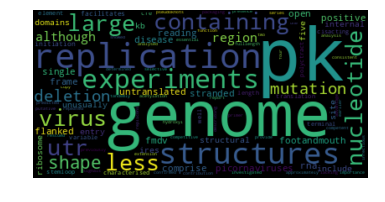

In [83]:
# Start with one review:

text = abstracts['abstract'][0]

# Create and generate a word cloud image:
wordcloud = wc.WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [84]:
print(f"Total number of abstracts: {len(abstracts['abstract'])}")
print(f"Number of nan abstracts: {abstracts['abstract'].value_counts()['nan']}")

Total number of abstracts: 10042
Number of nan abstracts: 1


In [85]:
abstracts = abstracts.loc[~(abstracts['abstract'] == 'nan')]

In [86]:
print(f"Total number of abstracts: {len(abstracts['abstract'])}")

Total number of abstracts: 10041


In [87]:
start_time = datetime.now()
wordcloud2 = wc.WordCloud(width=1920,height=1080,colormap='cool').generate(' '.join(abstracts['abstract'])) #joining all the abstracts into one huge text block and passing it as input to the wordcloud generator
end_time=datetime.now()
print(f'generated wordclouds from all {len(abstracts)} abstracts. time taken:{end_time-start_time}')

generated wordclouds from all 10041 abstracts. time taken:0:00:21.243029


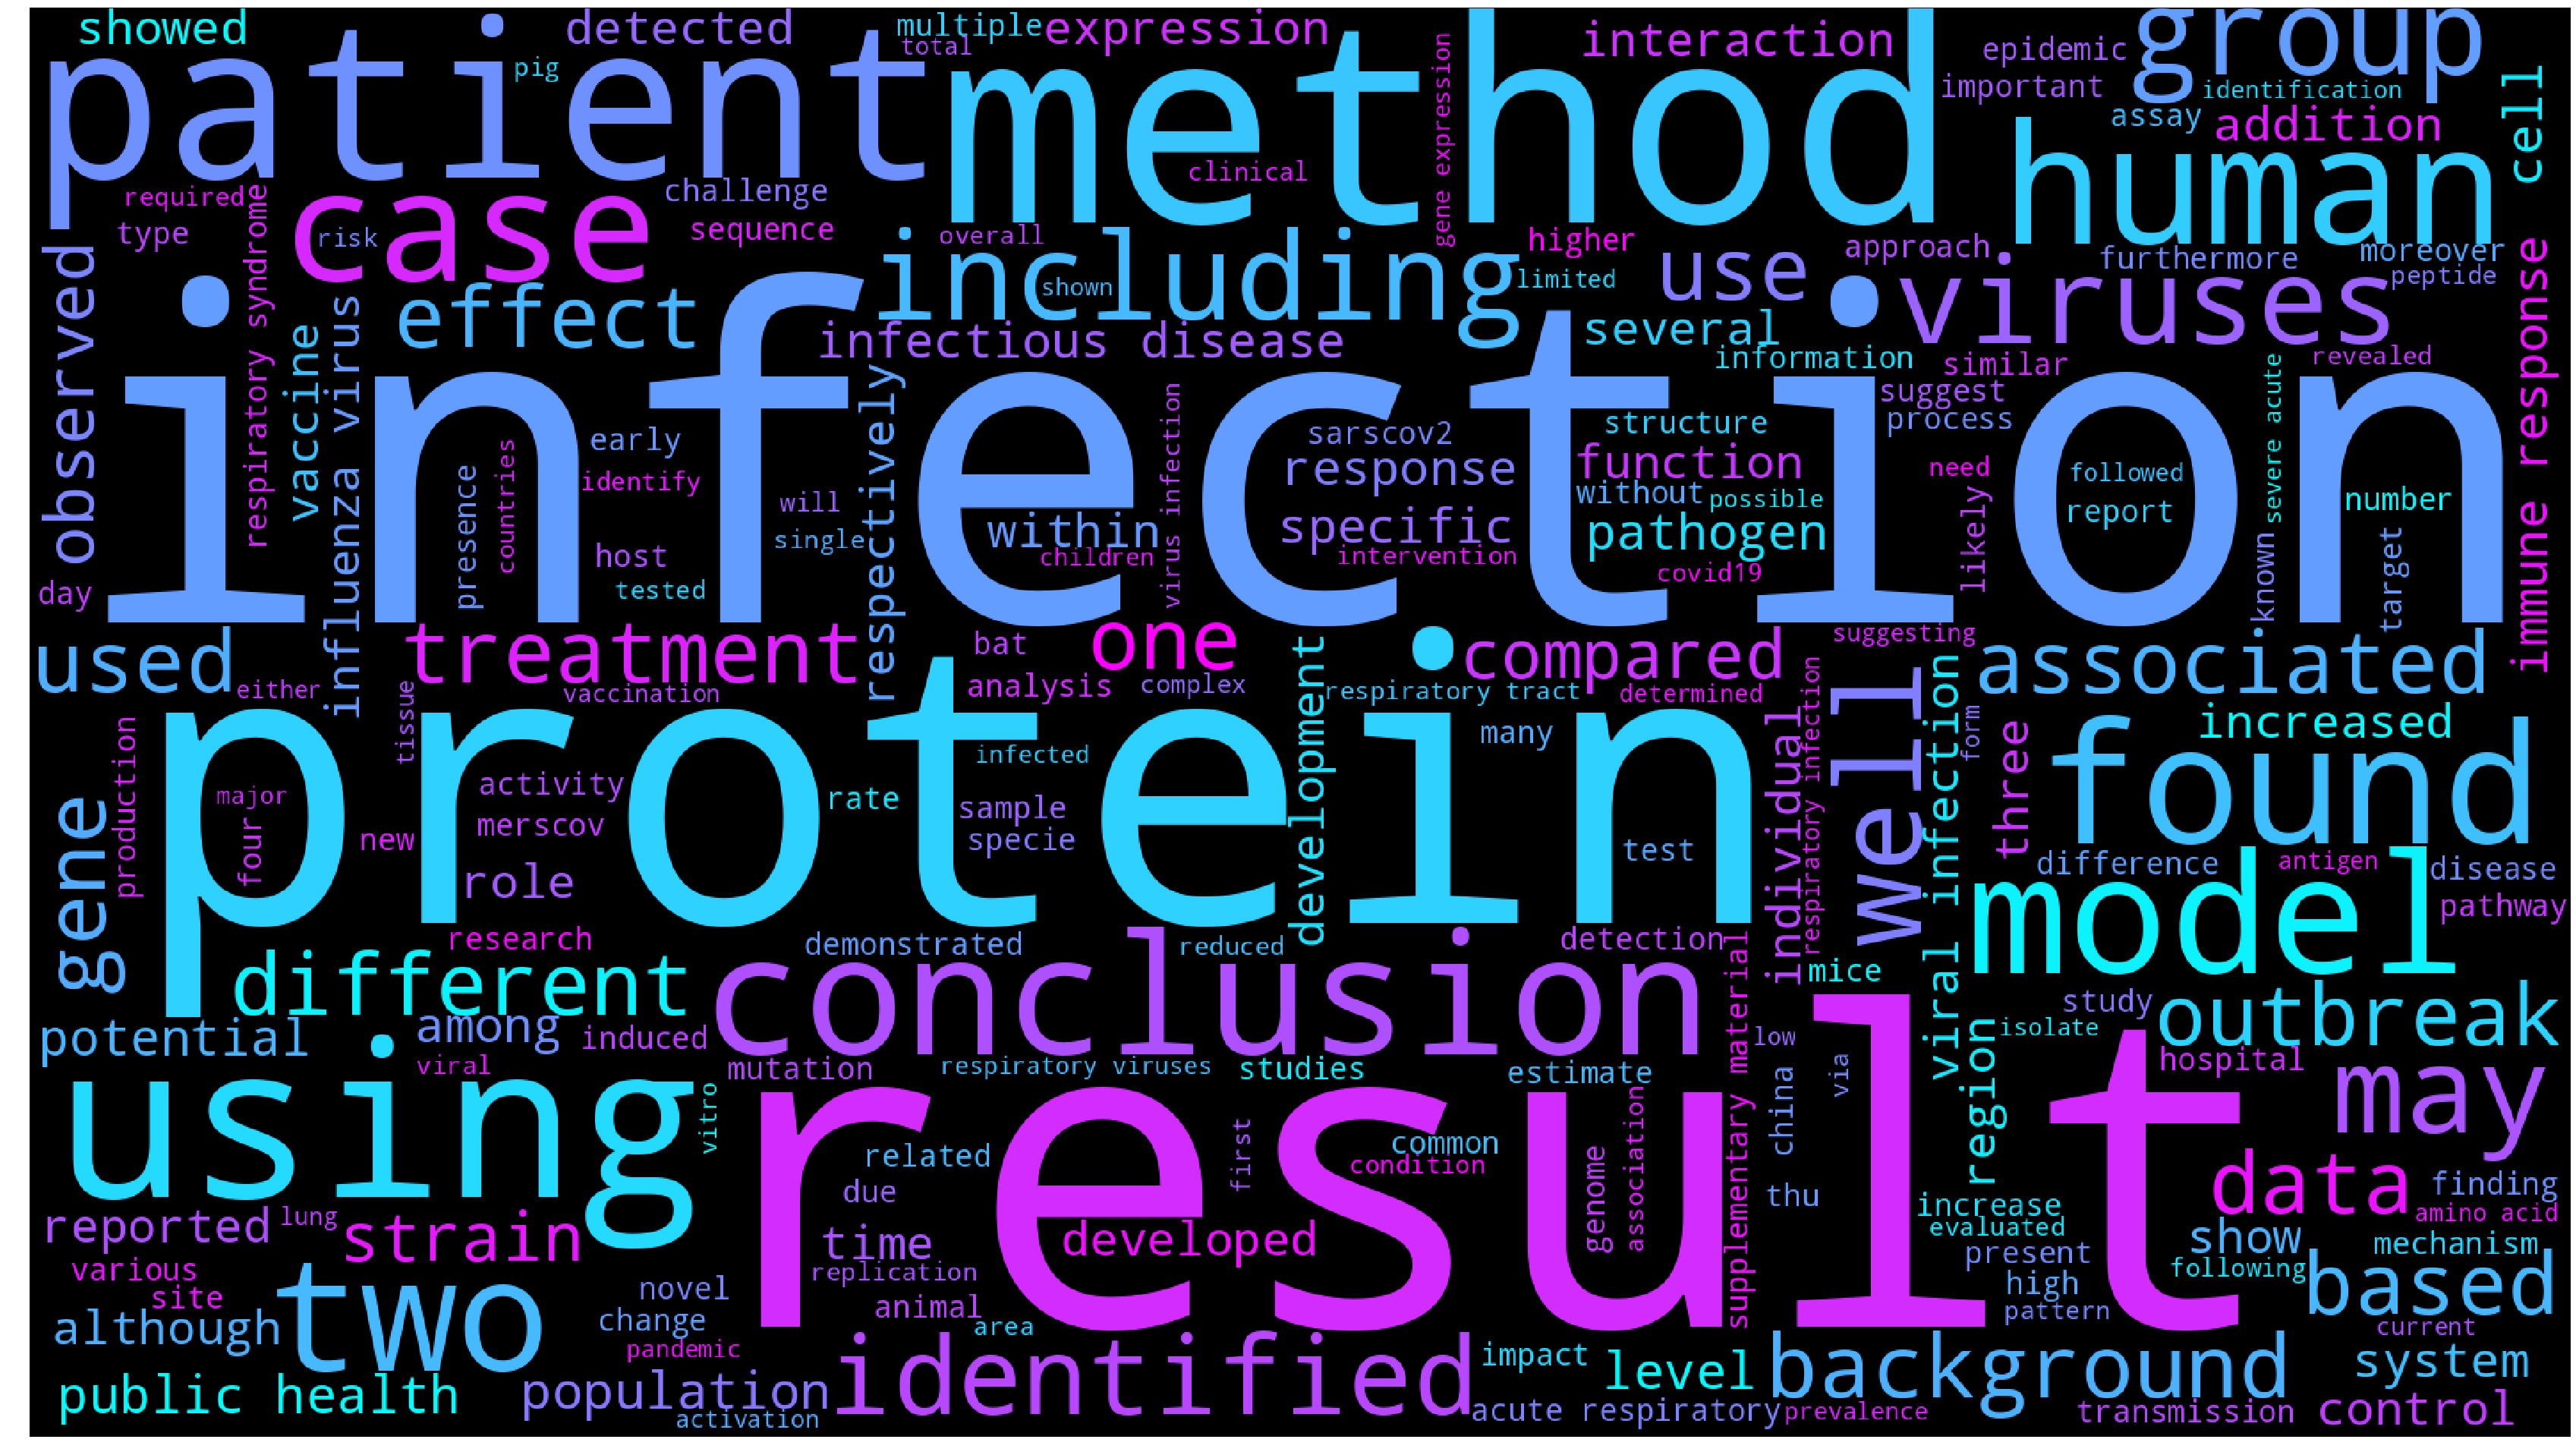

In [88]:
plot = plt.figure(figsize=(60, 60))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

# Forming Word Vectors for Dimensionality Reduction

In this section, we form word vectors of our abstracts and body texts in order to be able to modify the resulting vectors to find similar meaning words.
We are using the *Term Frequency- Inverse Document Frequency* calculation to form word vectors. It gives us an idea as to which terms are more frequent/common in the text and which are rarer and seemingly more representative terms in the body text/abstract.

Doing this also reduces our feature list to something more reasonable, given that if we look over the entire dataset, there will be upto [13 million](#Statistics) unique features.

In [89]:
abstract_tokens.describe()

count                                                 10042
unique                                                10040
top       [bleomycin, powerful, chemotherapeutic, drug, ...
freq                                                      2
Name: abstract, dtype: object

Though we have cleaned the abstracts and body texts and also tokenized them, the TDIDFVectorizer present in SciKit Learn does not need tokenized input, rather the whole collection of abstract texts. We provide the earlier cleaned and processed *abstract* and *bodytexts* DataTables for this purpose

In [90]:
abstracts[0:20]

,abstract,body_unique_words
0,the positive stranded rna genomes of picornavi...,704
1,during the past three months a new coronavirus...,1032
2,we integrate the human movement and healthcare...,378
3,the fast accumulation of viral metagenomic dat...,1371
4,infectious bronchitis ib causes significant ec...,1199
5,importance as with other traumatic events pand...,759
6,nipah virus niv came into limelight recently d...,1034
7,a novel coronavirus 2019ncov emerged in wuhan...,1205
8,introduction recent events highlight how emerg...,1131
9,faced with the current largescale public healt...,1309


In [91]:
bodytexts[0:20]

,body_text,body_unique_words
0,vp3 and vp0 which is further processed to vp2 ...,704
1,in december 2019 a novel coronavirus sarscov2 ...,1032
2,the 2019ncov epidemic has spread across china ...,378
3,metagenomic sequencing which allows us to dire...,1371
4,infectious bronchitis ib which is caused by in...,1199
5,evidence from prior pandemics suggests that al...,759
6,nipah is an infectious negativesense singlestr...,1034
7,in december 2019 a cluster of patients with pn...,1205
8,recent events highlight how emerging and reeme...,1131
9,the sudden outbreak of the new coronavirus sar...,1309


## TD-IDF - SciKitLearn

In [92]:
#Non Parallel implementation
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, max_features):
    
    vectorizer = TfidfVectorizer(max_features=max_features)
    X = vectorizer.fit_transform(text)
    return X


In [93]:
text = abstracts['abstract'].values
X = vectorize(text, 2 ** 12)
print(X.shape,type(X))

(10041, 4096) <class 'scipy.sparse.csr.csr_matrix'>


In [94]:
print(X[0],X[0].shape)

  (0, 3152)	0.0663273259154605
  (0, 1904)	0.01799380949109677
  (0, 3452)	0.09700091256720485
  (0, 2688)	0.1210710565619743
  (0, 3050)	0.08766631943064929
  (0, 2912)	0.06382860986883075
  (0, 1060)	0.09995420357340282
  (0, 3204)	0.06220718519022229
  (0, 1209)	0.09131179054687527
  (0, 2664)	0.03971660472883453
  (0, 846)	0.0792926949458448
  (0, 2073)	0.022735486056428684
  (0, 3750)	0.024736628855989224
  (0, 2624)	0.04701031705363487
  (0, 3730)	0.04400782896338346
  (0, 1587)	0.02724186769227129
  (0, 4019)	0.027774380502913962
  (0, 1955)	0.05082882622031972
  (0, 2545)	0.04943680111099969
  (0, 4035)	0.028787426514895343
  (0, 292)	0.044746607547580836
  (0, 2132)	0.08613565120704113
  (0, 1591)	0.0911964354635202
  (0, 1789)	0.04202431117617769
  (0, 246)	0.09716156744794062
  :	:
  (0, 3588)	0.0726137944621056
  (0, 1530)	0.07090082836697632
  (0, 864)	0.15754882205738047
  (0, 2105)	0.11352434296942006
  (0, 34)	0.07741003858798588
  (0, 3935)	0.10951726209223873
  (0, 32

In [97]:
start_time = datetime.now()
bodytext = bodytexts['body_text'].values
Xbody = vectorize(bodytext, 2 ** 12)
end_time = datetime.now()
print(f'Generated TF-IDF Calculated DTM for all {len(bodytext)} body texts. time taken:{end_time-start_time}')
print(Xbody.shape,type(Xbody))

Generated TF-IDF Calculated DTM for all 10042 body texts. time taken:0:00:43.784580
(10042, 4096) <class 'scipy.sparse.csr.csr_matrix'>


TODO: Plot this

## Spark Paralleizable implementation

[Spark Documentation Reference](https://spark.apache.org/docs/2.2.0/mllib-feature-extraction.html)

[Spark implementation reference](https://medium.com/@rezandry/find-most-relevance-text-data-using-pyspark-with-tf-idf-a4269a13e59)

In [98]:
from pyspark import SparkConf, SparkContext
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF

conf = SparkConf().setAppName("SparkTFIDF")
sc = SparkContext(conf=conf)

In [99]:
abstracts[0:10]

,abstract,body_unique_words
0,the positive stranded rna genomes of picornavi...,704
1,during the past three months a new coronavirus...,1032
2,we integrate the human movement and healthcare...,378
3,the fast accumulation of viral metagenomic dat...,1371
4,infectious bronchitis ib causes significant ec...,1199
5,importance as with other traumatic events pand...,759
6,nipah virus niv came into limelight recently d...,1034
7,a novel coronavirus 2019ncov emerged in wuhan...,1205
8,introduction recent events highlight how emerg...,1131
9,faced with the current largescale public healt...,1309


to work with pyspark and spark APIs, it would be better if we transformed our pandas dataframes to datastructures that it is more comfortable with, such as the SQLcontext Dataframe. This will hopefully make desigining the rest of the tf-idf parallelizable pipeline easier.

In [121]:
from pyspark import sql

In [125]:
spdf = sql.SQLContext(sc).createDataFrame(abstracts)

In [126]:
spdf

DataFrame[abstract: string, body_unique_words: bigint]

In [128]:
spdf.head(20)

[Row(abstract='the positive stranded rna genomes of picornaviruses comprise a single large open reading frame flanked by 5′ and 3′ untranslated regions utrs footandmouth disease virus fmdv has an unusually large 5′ utr 13 kb containing five structural domains these include the internal ribosome entry site ires which facilitates initiation of translation and the cisacting replication element cre less well characterised structures are a 5′ terminal 360 nucleotide stemloop a variable length polyctract of approximately 100200 nucleotides and a series of two to four tandemly repeated pseudoknots pks we investigated the structures of the pks by selective 2′ hydroxyl acetylation analysed by primer extension shape analysis and determined their contribution to genome replication by mutation and deletion experiments shape and mutation experiments confirmed the importance of the previously predicted pk structures for their function deletion experiments showed that although pks are not essential f

again here, the HashingTF(term frequency hashing class) requires a string input, so we will again use the *abstracts* and the *bodytexts* datatables.

In [105]:
start_time = datetime.now()
hashingTF = HashingTF()
tf = hashingTF.transform(abstracts['abstract'])
tfrdd = sc.parallelize(tf)

print(type(tf),type(tfrdd))

end_time = datetime.now()
print(f'Read all {len(abstracts)} abstracts into RDDs. time taken: {end_time-start_time}')

<class 'pyspark.mllib.linalg.SparseVector'> <class 'pyspark.rdd.RDD'>
Read all 10041 abstracts into RDDs. time taken: 0:00:28.234637


In [ ]:
tfrdd2 = sc.parallelize(hashingTF.transform(abstracts['abstract']))

In [115]:
tfrdd2.top(30)

[2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0]

In [112]:
tf

SparseVector(1048576, {67: 1.0, 93: 1.0, 177: 1.0, 193: 1.0, 409: 1.0, 649: 1.0, 880: 1.0, 989: 1.0, 1082: 1.0, 1090: 1.0, 1150: 1.0, 1265: 1.0, 1288: 1.0, 1334: 1.0, 1350: 1.0, 1365: 1.0, 1392: 1.0, 1756: 1.0, 1891: 1.0, 2051: 1.0, 2059: 1.0, 2152: 1.0, 2193: 1.0, 2243: 1.0, 2293: 1.0, 2344: 1.0, 2387: 1.0, 2492: 1.0, 2520: 1.0, 2536: 1.0, 2541: 1.0, 2587: 1.0, 2685: 1.0, 2687: 1.0, 2727: 1.0, 2771: 1.0, 2786: 1.0, 2828: 1.0, 2941: 1.0, 3182: 1.0, 3294: 1.0, 3328: 1.0, 3361: 1.0, 3390: 1.0, 4271: 1.0, 4297: 1.0, 4444: 1.0, 4544: 1.0, 4994: 1.0, 5025: 1.0, 5056: 1.0, 5219: 1.0, 5235: 1.0, 5236: 1.0, 5404: 1.0, 5642: 1.0, 5702: 1.0, 5713: 1.0, 5825: 1.0, 5947: 1.0, 5986: 1.0, 6080: 1.0, 6115: 1.0, 6234: 1.0, 6403: 1.0, 6406: 1.0, 6428: 1.0, 6540: 1.0, 6617: 1.0, 6640: 1.0, 6729: 1.0, 6816: 1.0, 6868: 1.0, 6964: 1.0, 6995: 1.0, 7335: 1.0, 7431: 1.0, 7446: 1.0, 7487: 1.0, 7587: 1.0, 7672: 1.0, 7740: 1.0, 7890: 1.0, 7924: 1.0, 7972: 1.0, 8143: 1.0, 8173: 1.0, 8218: 1.0, 8221: 1.0, 8307: 1.

In [113]:
tfrdd
print(tfrdd.top(1430))

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [116]:
# While applying HashingTF only needs a single pass to the data, applying IDF needs two passes:
# First to compute the IDF vector and second to scale the term frequencies by IDF.
tfrdd2.cache()

ParallelCollectionRDD[13] at parallelize at PythonRDD.scala:195

In [117]:
idf = IDF().fit(tfrdd)

Py4JJavaError: An error occurred while calling o172.fitIDF.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 8 in stage 7.0 failed 4 times, most recent failure: Lost task 8.3 in stage 7.0 (TID 167, 129.82.44.160, executor 4): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'float'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.foldLeft(TraversableOnce.scala:157)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.aggregate(TraversableOnce.scala:214)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.mllib.feature.IDF.fit(IDF.scala:54)
	at org.apache.spark.mllib.feature.IDF.fit(IDF.scala:67)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.fitIDF(PythonMLLibAPI.scala:669)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'float'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.foldLeft(TraversableOnce.scala:157)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.aggregate(TraversableOnce.scala:214)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [107]:
tfidf = idf.transform(tfrdd)

Py4JJavaError: An error occurred while calling o125.fitIDF.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 12 in stage 2.0 failed 4 times, most recent failure: Lost task 12.3 in stage 2.0 (TID 70, 129.82.44.160, executor 2): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'float'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.foldLeft(TraversableOnce.scala:157)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.aggregate(TraversableOnce.scala:214)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1889)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1877)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1876)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1876)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:926)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:926)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2110)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2059)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2048)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:737)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2158)
	at org.apache.spark.rdd.RDD$$anonfun$fold$1.apply(RDD.scala:1098)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1092)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1.apply(RDD.scala:1161)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1137)
	at org.apache.spark.mllib.feature.IDF.fit(IDF.scala:54)
	at org.apache.spark.mllib.feature.IDF.fit(IDF.scala:67)
	at org.apache.spark.mllib.api.python.PythonMLLibAPI.fitIDF(PythonMLLibAPI.scala:669)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/serializers.py", line 393, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/s/chopin/b/grad/sanketm/spark-2.4.4-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'float'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.foldLeft(TraversableOnce.scala:157)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.aggregate(TraversableOnce.scala:214)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$24.apply(RDD.scala:1145)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$treeAggregate$1$$anonfun$25.apply(RDD.scala:1146)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.RDD$$anonfun$mapPartitions$1$$anonfun$apply$23.apply(RDD.scala:801)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:324)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:288)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:55)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [ ]:
sc.stop()

# t-SNE

# Clustering 

[Ref - Scikit learn](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html#sphx-glr-auto-examples-text-plot-document-clustering-py)

### Elbow method and Silhouette method

# Classification and cross validation with Pytorch

### F Score, Precision, Recall, and Accuracy

# Visualization and stuff

https://cdn.oreillystatic.com/en/assets/1/event/261/Text%20analytics%20and%20new%20visualization%20techniques%20Presentation.pdf

# References

1. [COVID-19 Open Research Dataset Challenge (CORD-19)](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/)
2. [How to build a topic-based search engine](https://www.smithinst.co.uk/insights/build-topic-based-search-engine/)
3. W. Buntine et al., "A Scalable Topic-Based Open Source Search Engine," IEEE/WIC/ACM International Conference on Web Intelligence (WI'04), Beijing, China, 2004, pp. 228-234.
4. [Semantic Topic Modeling for Search Queries at Google](https://gofishdigital.com/semantic-topic-modeling/)
5. GRANT, C.; PAZHAYIDAM GEORGE, C.; KANJILAL, V.; NIRKHIWALE, S.; WILSON, J.; WANG, D.. A Topic-Based Search, Visualization, and Exploration System. Florida Artificial Intelligence Research Society Conference, North America, apr. 2015. Available at: <https://www.aaai.org/ocs/index.php/FLAIRS/FLAIRS15/paper/view/10445/10360>. Date accessed: 25 Apr. 2020.